Ссылка на датасет https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

os.listdir('./Fish_Dataset')

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Segmentation_example_script.m',
 'README.txt',
 'Striped Red Mullet',
 'license.txt',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

Hourse Mackerel
Black Sea Sprat
Sea Bass
Red Mullet
Trout
Striped Red Mullet
Shrimp
Gilt-Head Bream
Red Sea Bream


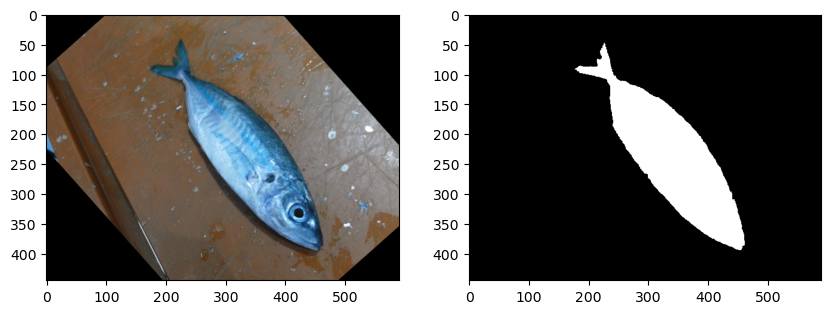

In [2]:
imgs = list()
masks = list()

root = './Fish_Dataset'

for fish_name in os.listdir(root):
    if not os.path.isdir(os.path.join(root, fish_name)):
        continue
    
    imgs_dir = os.path.join(root, fish_name, fish_name)
    masks_dir = os.path.join(root, fish_name, fish_name+' GT')
    
    for fn in os.listdir(imgs_dir)[:100]:
        imgs.append(cv2.imread(os.path.join(imgs_dir, fn)))
        
    for fn in os.listdir(masks_dir)[:100]:
        masks.append(cv2.imread(os.path.join(masks_dir, fn)))
        
    print(fish_name)
        
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].imshow(imgs[0])
axes[1].imshow(masks[0])

In [3]:
img_sizes = np.array([img.shape for img in imgs])

for shape, n in zip(*np.unique(img_sizes, axis=0, return_counts=True)):
    print(shape, n)

[445 590   3] 900


In [4]:
X = np.empty((len(imgs), 224, 224, 3))
y = np.empty((len(masks), 224, 224))

for i, img in enumerate(imgs):
    X[i] = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC) / 255
    
for i, mask in enumerate(masks):
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    y[i] = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_CUBIC) / 255

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train.shape, X_val.shape 

((720, 224, 224, 3), (180, 224, 224, 3))

# Conv-DeconvNet

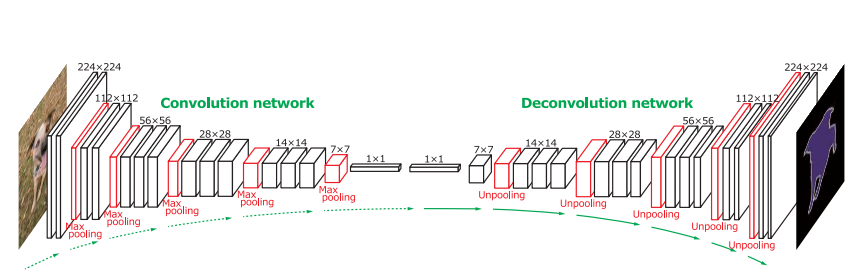

In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Flatten

model = Sequential()

# CONV part

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

# DECONV part

model.add(Conv2DTranspose(512, (2, 2), strides=(2, 2), activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model.add(Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model.add(Conv2DTranspose(128, (2, 2), strides=(2, 2), activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

model.add(Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

model.add(Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu'))
model.add(Conv2D(32, (1, 1), padding='same', activation='relu'))
model.add(Conv2D(2, (1, 1), padding='same', activation='softmax'))

model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,
                    callbacks=[EarlyStopping(patience=8, restore_best_weights=True), ReduceLROnPlateau(patience=4, factor=0.5)])

Epoch 1/100
23/23 [==============================] - 31s 381ms/step - loss: 13.2635 - accuracy: 0.8223 - val_loss: 0.5914 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 5s 213ms/step - loss: 0.5740 - accuracy: 0.8318 - val_loss: 0.5550 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 5s 213ms/step - loss: 0.4114 - accuracy: 0.8318 - val_loss: 0.3403 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 5s 213ms/step - loss: 0.3352 - accuracy: 0.8318 - val_loss: 0.3072 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 5s 213ms/step - loss: 0.3096 - accuracy: 0.8321 - val_loss: 0.2827 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 6/100
23/23 [==============================] - 5s 227ms/step - loss: 0.3013 - accuracy: 0.8419 - val_loss: 0.2816 - val_accuracy: 0.8688 - lr: 0.0010
Epoch 7/100
23/23 [==============================] - 5s 224ms/

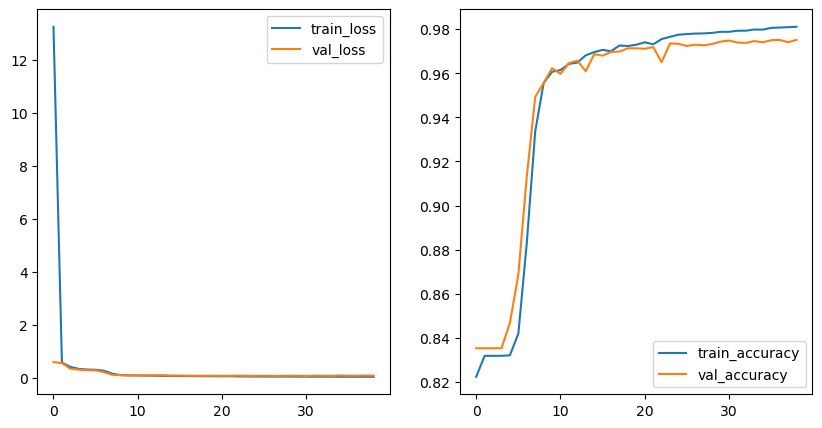

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')

axes[1].plot(history.history['accuracy'], label='train_accuracy')
axes[1].plot(history.history['val_accuracy'], label='val_accuracy')

axes[0].legend()
axes[1].legend()

In [9]:
model.evaluate(X_val, y_val)

6/6 [==============================] - 0s 63ms/step - loss: 0.0693 - accuracy: 0.9749


[0.06928741931915283, 0.9748691320419312]

In [10]:
del model

# UNet

По сути, UNet - модификация Conv-DeconvNet. Ниже заметно, что модификация дает плоды в виде лучшего качества.

Также в конце приведены графические примеры предсказаний модели

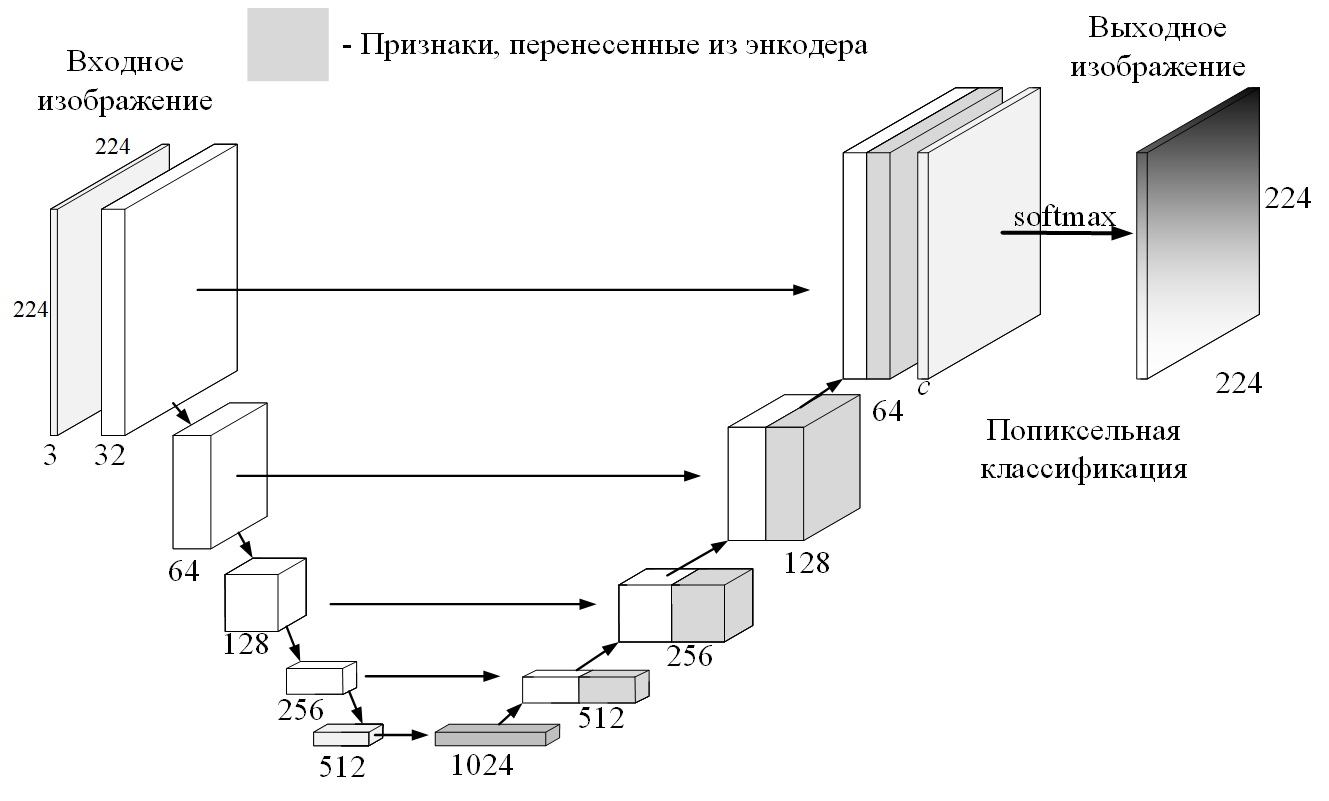

In [11]:
from tensorflow.keras.layers import Input, Concatenate

inp = Input(shape=(224, 224, 3))

# Conv part

x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(inp)
x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(x1)

x2 = MaxPooling2D((2, 2))(x1) # 112
x2 = Conv2D(64, (3, 3), padding='same', activation='relu')(x2)
x2 = Conv2D(64, (3, 3), padding='same', activation='relu')(x2)

x3 = MaxPooling2D((2, 2))(x2) # 56
x3 = Conv2D(128, (3, 3), padding='same', activation='relu')(x3)
x3 = Conv2D(128, (3, 3), padding='same', activation='relu')(x3)

x4 = MaxPooling2D((2, 2))(x3) # 28
x4 = Conv2D(256, (3, 3), padding='same', activation='relu')(x4)
x4 = Conv2D(256, (3, 3), padding='same', activation='relu')(x4)

x5 = MaxPooling2D((2, 2))(x4) # 14
x5 = Conv2D(512, (3, 3), padding='same', activation='relu')(x5)
x5 = Conv2D(512, (3, 3), padding='same', activation='relu')(x5)

x6 = MaxPooling2D((2, 2))(x5) # 7

# Deconv part

u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='relu')(x6) # 14
u5 = Conv2D(256, (3, 3), padding='same', activation='relu')(u5)
u5 = Conv2D(256, (3, 3), padding='same', activation='relu')(u5)
u5 = Concatenate()([x5, u5])

u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), activation='relu')(u5) # 28
u4 = Conv2D(128, (3, 3), padding='same', activation='relu')(u4)
u4 = Conv2D(128, (3, 3), padding='same', activation='relu')(u4)
u4 = Concatenate()([x4, u4])

u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu')(u4) # 56
u3 = Conv2D(64, (3, 3), padding='same', activation='relu')(u3)
u3 = Conv2D(64, (3, 3), padding='same', activation='relu')(u3)
u3 = Concatenate()([x3, u3])

u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu')(u3) # 112
u2 = Conv2D(32, (3, 3), padding='same', activation='relu')(u2)
u2 = Conv2D(32, (3, 3), padding='same', activation='relu')(u2)
u2 = Concatenate()([x2, u2])

u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu')(u2) # 224
u1 = Conv2D(32, (3, 3), padding='same', activation='relu')(u1)
u1 = Conv2D(32, (3, 3), padding='same', activation='relu')(u1)
u1 = Concatenate()([x1, u1])

out = Conv2D(2, (1, 1), padding='same', activation='softmax')(u1)

model = Model(inputs=inp, outputs=out)

model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 224, 224, 32  9248        ['conv2d_20[0][0]']              
                                )                                                             

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,
                    callbacks=[EarlyStopping(patience=8, restore_best_weights=True), 
                               ReduceLROnPlateau(patience=4, factor=0.5)])

Epoch 1/100
23/23 [==============================] - 19s 263ms/step - loss: 0.6606 - accuracy: 0.8274 - val_loss: 0.4187 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 4s 190ms/step - loss: 0.4583 - accuracy: 0.8772 - val_loss: 0.2021 - val_accuracy: 0.9355 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 5s 204ms/step - loss: 0.1397 - accuracy: 0.9548 - val_loss: 0.1188 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 4s 189ms/step - loss: 0.1047 - accuracy: 0.9608 - val_loss: 0.1076 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 5s 207ms/step - loss: 0.0957 - accuracy: 0.9619 - val_loss: 0.1014 - val_accuracy: 0.9592 - lr: 0.0010
Epoch 6/100
23/23 [==============================] - 5s 204ms/step - loss: 0.0900 - accuracy: 0.9633 - val_loss: 0.0963 - val_accuracy: 0.9612 - lr: 0.0010
Epoch 7/100
23/23 [==============================] - 5s 203ms/s

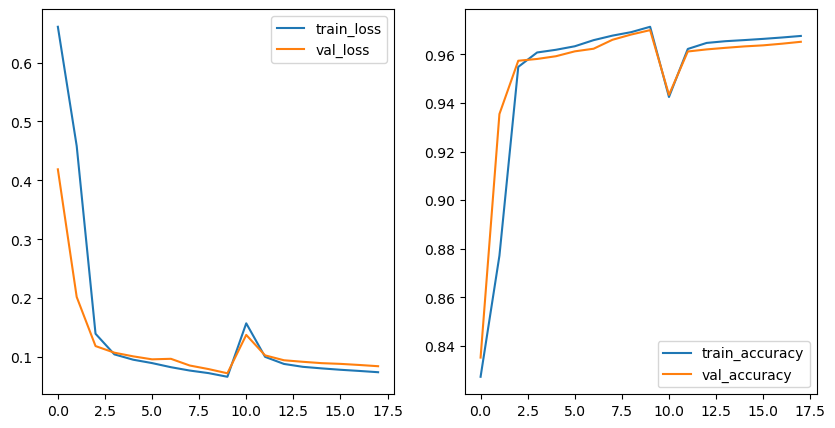

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')

axes[1].plot(history.history['accuracy'], label='train_accuracy')
axes[1].plot(history.history['val_accuracy'], label='val_accuracy')

axes[0].legend()
axes[1].legend()

In [14]:
model.evaluate(X_val, y_val)

6/6 [==============================] - 0s 54ms/step - loss: 0.0726 - accuracy: 0.9700


[0.0726454108953476, 0.9699640870094299]

6/6 [==============================] - 1s 48ms/step


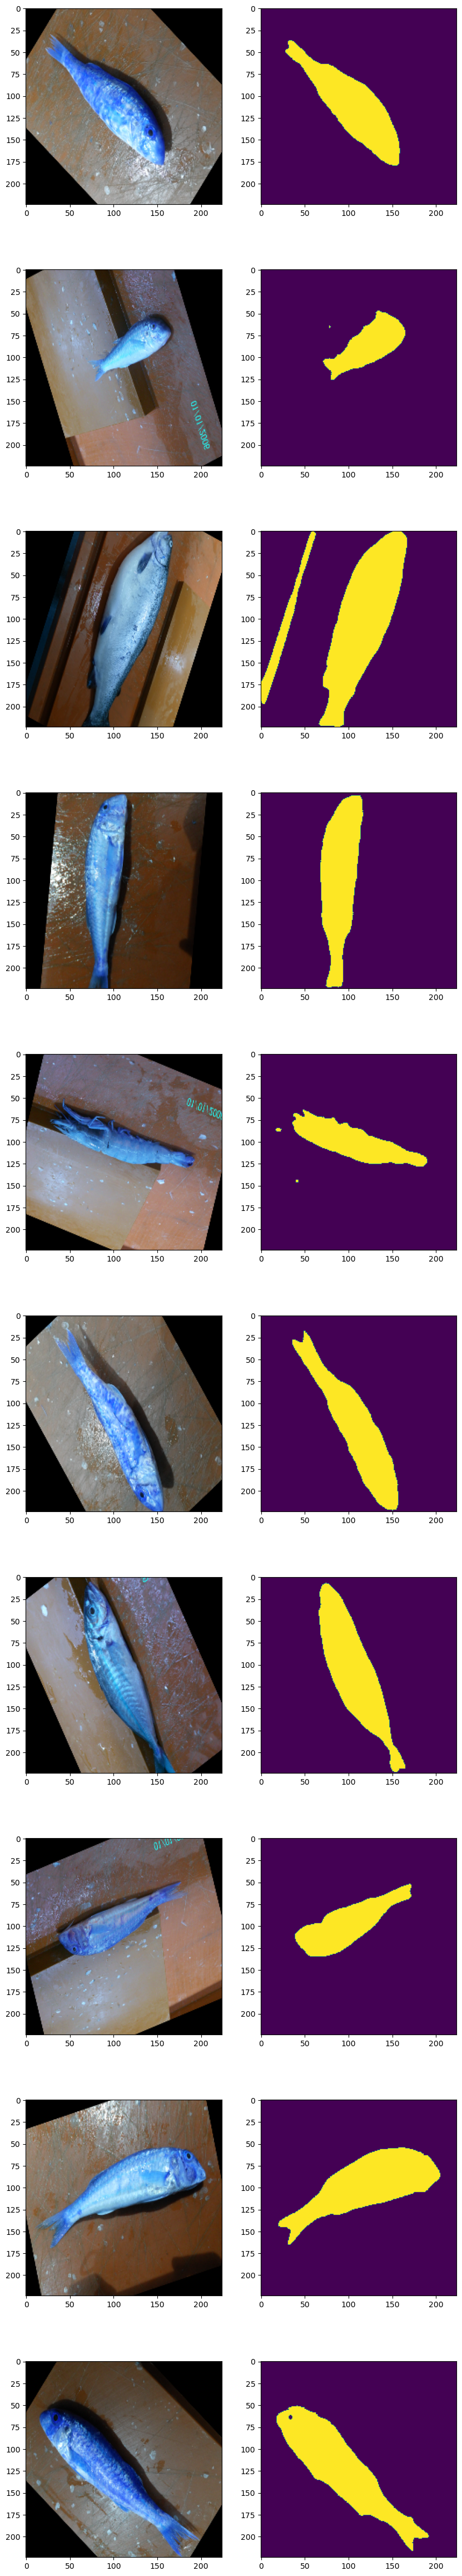

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=10, figsize=(10, 60))

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=-1)

for i in range(10):
    axes[i, 0].imshow(X_val[i])
    axes[i, 1].imshow(y_pred[i])